In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style("darkgrid")

from math import sqrt, pi

from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split

from IPython.core.display import display, HTML

## Functions 

In [2]:
def prepareData(sklearnDataSet):
    
    X, y = sklearnDataSet(return_X_y=True)
    data  = np.hstack([X,y.reshape(-1,1)])
    cols_name_lst = [f"feature_{i+1}" for i in range(X.shape[1])] + ["target"]
    return pd.DataFrame(data, columns = cols_name_lst)

def getStats(df):
    
    classes = list(map(int, df.target.unique()))
    return df.groupby("target")\
             .agg(["mean","std"]).T\
             .reset_index()\
             .rename(columns = {"level_0":"feature","level_1":"statistic"})\
             .pivot(index='feature', columns="statistic", values=classes)\
             .T

def gaussian(x, mu, sig):
    aux = 2*(sig**2)
    return np.exp(-(x - mu)**2 /aux)/sqrt(aux)

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0\xa0\xa0"
    display(HTML(output))
    
def gaussian_plot(s, point):
    
    fig = plt.figure(figsize=(20,4))
    mean_lst = []
    std_lst = []
    
    feature_point = point[s.name]
    
    #Split column in means and standard deviations
    for mean, std in zip(s[0::2],s[1::2]):
        mean_lst.append(mean)
        std_lst.append(std)

    max_mean = max(mean_lst)
    min_mean = min(mean_lst)
    max_std  = max(std_lst)  
    
    #Make x axis 
    x = np.linspace(min(mean_lst)-3*max_std, max(mean_lst)+3*max_std, 5000)
    
    #Store likelihood for every class
    y_probability = []
    
    for index, stats in enumerate(zip(mean_lst, std_lst)):
        
        mean, std = stats
        
        y = [gaussian(i, mean, std) for i in x]
        plt.title(fr"PDF: {s.name.upper()}")
        plt.plot(x, y, lw=2,label=fr"$\mu: {round(mean,2)} , \sigma: {round(std,2)}$")
        
        # Calculate likelihood for an given point
        y_point = gaussian(feature_point, mean, std)
        #Store the log to prevent underflow while multiplicating
        y_probability.append(np.log(y_point))
        plt.vlines(x=feature_point, ymin=0, ymax = y_point, linewidth=1, color='k', linestyles = "dashdot")
        plt.hlines(y=y_point, xmin=x[0], xmax = feature_point, linewidth=1, color='k', linestyles = "dashdot")
        
    first_legend = plt.legend(loc="upper left", title=r"Stats", fancybox=True, fontsize=16)
    plt.setp(first_legend.get_title(),fontsize=18)
    plt.gca().add_artist(first_legend)
    
    second_legend = plt.legend(list(range(len(s)//2)),
                               title="Classes",
                               fancybox=True, 
                               fontsize=16,
                               loc='upper right')    
    
    plt.setp(second_legend.get_title(),fontsize=18)       
    plt.show()
    plt.close()
    
    return pd.Series(y_probability)

## Loading Data 

In [3]:
cancer_df = prepareData(load_breast_cancer)
iris_df = prepareData(load_iris)

In [4]:
#Set the dataset to work with
df = iris_df

In [5]:
df_train, df_test = train_test_split(df, test_size = 0.1, random_state = 42)
display_side_by_side([df_train.head(3), df_test.head(3)], ["Train", "Test"])
#df_train = df_train.reset_index(drop = True)
#df_test = df_test.reset_index(drop = True)

,feature_1,feature_2,feature_3,feature_4,target
56,6.300000,3.300000,4.700000,1.600000,1.000000
104,6.500000,3.000000,5.800000,2.200000,2.000000
69,5.600000,2.500000,3.900000,1.100000,1.000000
,feature_1,feature_2,feature_3,feature_4,target
73,6.100000,2.800000,4.700000,1.200000,1.000000
18,5.700000,3.800000,1.700000,0.300000,0.000000
118,7.700000,2.600000,6.900000,2.300000,2.000000


## Theory 

We want to calculate the probability of Y given a set of features:

$$
P(y|x_1, ..., x_n) = \frac{P(y)P(x_1, ..., x_n|y)}{P(x_1, ..., x_n)}\\
$$

Using the assumption of conditional independence between every pair of features:

$$
P(y|x_1, ..., x_n) = \frac{P(y)\prod_{i=1}^{n}P(x_i|y)}{P(x_1, ..., x_n)}\\
$$

Since $P(x_1, ..., x_n)$ is constant given the input, we can use the following classification rule:

$$
P(y|x_1, ..., x_n) \propto P(y)\prod_{i=1}^{n}P(x_i|y) \\
$$

In order to deal with underflow the logarithmic operation is used:

$$
logP(y|x_1, ..., x_n) \propto logP(y) + \sum_{i=1}^{n}logP(x_i|y) \\
$$

**Gaussian equation**:
    
$$
P(X_i | y) = \frac{1}{\sqrt{2\pi\sigma_y^{2}}}\exp{\frac{-(x_i - \mu_y)^{2}}{2\sigma_y^{2}}}
$$

## Gaussian Naive Bayes 

**Assumption:** The variables exhibit a Gaussian probability distribution.

### Get ```mean``` and ```standard deviation```

In [6]:
stats_df = getStats(df_train)
stats_df

feature      feature_1  feature_2  feature_3  feature_4
  statistic                                            
1 mean        5.915909   2.777273   4.250000   1.322727
  std         0.529565   0.321959   0.473728   0.205578
2 mean        6.559574   2.974468   5.542553   2.014894
  std         0.633026   0.326022   0.525334   0.277394
0 mean        4.975000   3.427273   1.459091   0.247727
  std         0.344475   0.387817   0.179558   0.104522

In [7]:
stats_df.index = map(lambda x: '_'.join(map(str,x)), stats_df.index)
stats_df = stats_df[sorted(stats_df.columns, key=lambda x: int(x.split('_')[1]))]
qtd_classes = len(stats_df)//2
stats_df.sort_index(inplace=True)
stats_df

feature,feature_1,feature_2,feature_3,feature_4
0_mean,4.975000,3.427273,1.459091,0.247727
0_std,0.344475,0.387817,0.179558,0.104522
1_mean,5.915909,2.777273,4.250000,1.322727
1_std,0.529565,0.321959,0.473728,0.205578
2_mean,6.559574,2.974468,5.542553,2.014894
2_std,0.633026,0.326022,0.525334,0.277394


### Get ```prior probability``` 

In [8]:
#prior probability
prior_df = df["target"]\
             .value_counts(normalize=True)\
             .reset_index(name="prior_probability")\
             .rename(columns = {"index":"class"})\
             .set_index("class")
prior_df

,prior_probability
class,
2.0,0.333333
1.0,0.333333
0.0,0.333333


### Choose an example 

In [9]:
select_id = 5
point = df_test.iloc[select_id,:].to_dict()
print(f"The Class is: {df_test.iloc[select_id,-1]}")

The Class is: 0.0


In [10]:
stats_df

feature,feature_1,feature_2,feature_3,feature_4
0_mean,4.975000,3.427273,1.459091,0.247727
0_std,0.344475,0.387817,0.179558,0.104522
1_mean,5.915909,2.777273,4.250000,1.322727
1_std,0.529565,0.321959,0.473728,0.205578
2_mean,6.559574,2.974468,5.542553,2.014894
2_std,0.633026,0.326022,0.525334,0.277394


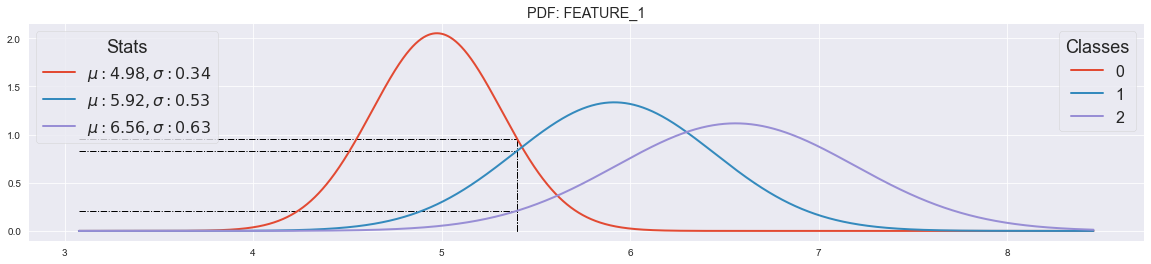

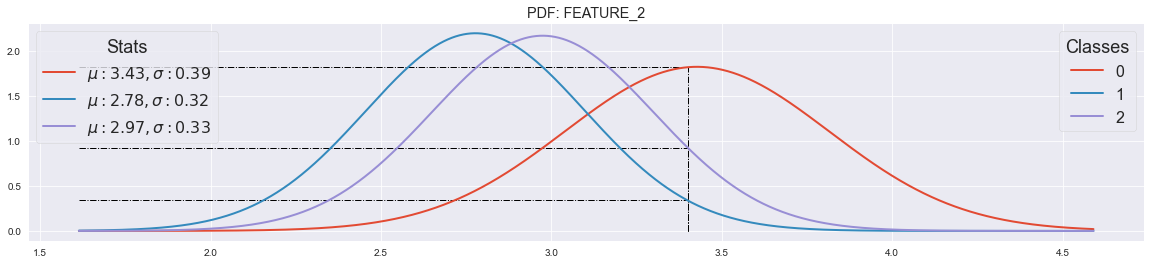

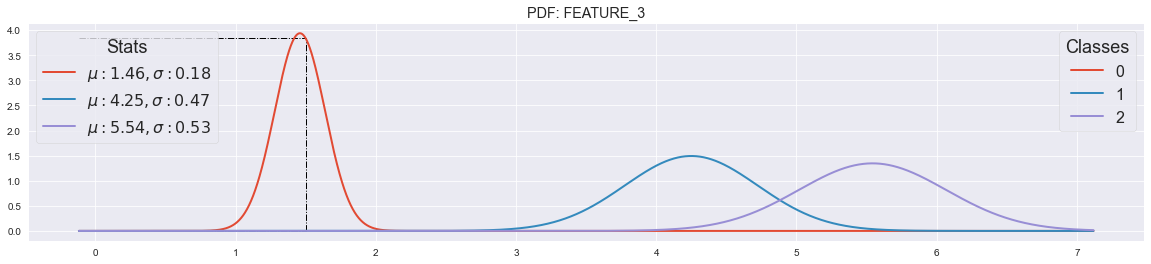

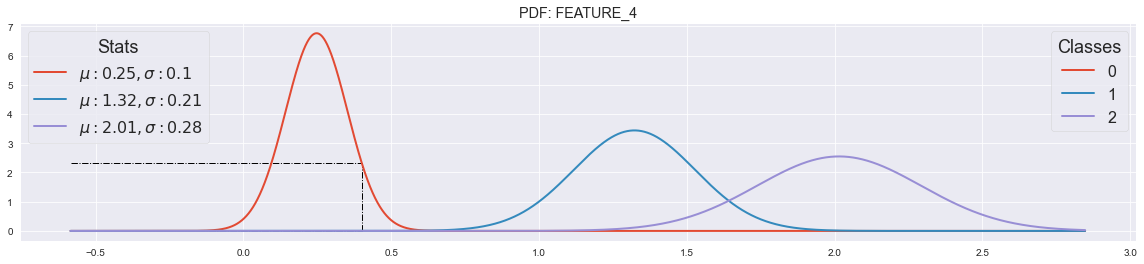

In [11]:
result = stats_df.apply(gaussian_plot, args=[point], result_type = "expand")

In [12]:
cols = {col:fr"P(y|{col})" for col in result.columns}
result.rename(columns=cols,inplace = True)
result.index.name = "class"
result

feature,P(y|feature_1),P(y|feature_2),P(y|feature_3),P(y|feature_4)
class,,,,
0,-0.041924,0.598177,1.344731,0.850585
1,-0.185420,-1.083774,-16.448546,-8.837786
2,-1.567069,-0.077588,-29.310934,-16.010155


In [13]:
final_stats = pd.concat([prior_df,result],axis=1)

In [14]:
final_stats

,prior_probability,P(y|feature_1),P(y|feature_2),P(y|feature_3),P(y|feature_4)
class,,,,,
0.0,0.333333,-0.041924,0.598177,1.344731,0.850585
1.0,0.333333,-0.185420,-1.083774,-16.448546,-8.837786
2.0,0.333333,-1.567069,-0.077588,-29.310934,-16.010155


In [15]:
final_stats.apply(lambda x: x.sum(), axis=1)

class
0.0     3.084902
1.0   -26.222192
2.0   -46.632413
dtype: float64

In [16]:
def get_gaussian_proba(s, stats_df, data):
    
    for feature_val in s:
        
        stats_ser = stats_df[f"{s.name}"]
        for index, stats in enumerate(zip(stats_ser[0::2],stats_ser[1::2])):
            mean, std = stats
            data[f"P({index}|{s.name})"].append(gaussian(feature_val, mean, std))
            
    return None

In [17]:
qtd_samples = df_test.shape[1]-1
data = {f"P({i%qtd_classes}|feature_{(i//qtd_classes)+1})":[] for i in range(qtd_samples*qtd_classes)}
_ = df_test.iloc[:,:-1].apply(get_gaussian_proba, args = [stats_df,data])

In [18]:
proba_test_df=pd.DataFrame(data)
proba_test_df.head(3)

,P(0|feature_1),P(1|feature_1),P(2|feature_1),P(0|feature_2),P(1|feature_2),P(2|feature_2),P(0|feature_3),P(1|feature_3),P(2|feature_3),P(0|feature_4),P(1|feature_4),P(2|feature_4)
0,9.915039e-03,1.256970,0.858246,0.492915,2.190799,1.879542,7.127852e-71,9.506415e-01,3.719454e-01,6.397439e-18,2.878188,3.407353e-02
1,2.241089e-01,1.228769,0.444302,1.148895,0.014143,0.087893,1.601006e+00,7.623289e-07,3.245467e-12,5.969867e+00,0.000015,1.279980e-08
2,5.294056e-14,0.004581,0.220443,0.187397,1.887351,1.121401,1.629616e-199,2.393265e-07,4.777278e-02,1.302930e-83,0.000043,1.503135e+00


In [19]:
proba_test_df = proba_test_df.applymap(np.log)
proba_test_df.head(3)

,P(0|feature_1),P(1|feature_1),P(2|feature_1),P(0|feature_2),P(1|feature_2),P(2|feature_2),P(0|feature_3),P(1|feature_3),P(2|feature_3),P(0|feature_4),P(1|feature_4),P(2|feature_4)
0,-4.613703,0.228704,-0.152865,-0.707418,0.784266,0.631028,-161.519532,-0.050618,-0.989008,-39.590634,1.057161,-3.379234
1,-1.495623,0.206013,-0.811252,0.138801,-4.258565,-2.431635,0.470632,-14.086888,-26.453762,1.786725,-11.139437,-18.173836
2,-30.569607,-5.385876,-1.512115,-1.674525,0.635174,0.114579,-457.726089,-15.245437,-3.041299,-190.849947,-10.063900,0.407553


In [20]:
final_proba_df = []

for i in range(qtd_classes):
    ser = proba_test_df.filter(regex = fr"{i}\|").sum(axis=1)
    ser.name = i
    final_proba_df.append(ser)
    
final_proba_df = pd.concat(final_proba_df,axis=1)
final_proba_df.columns.name = "classes"
final_proba_df.index.name = "samples"
final_proba_df = final_proba_df.T

In [21]:
def find_class(x, prior_proba):
    
    best_value = {}
    
    for target, value in zip(x.index, x.values):
        best_value[target] = prior_proba[target]*value
        
    return max(best_value, key=best_value.get)

y_hat = final_proba_df.apply(find_class, args = [prior_df.to_dict()["prior_probability"]])
y_hat.head(5)

samples
0    1
1    0
2    2
3    1
4    1
dtype: int64

In [22]:
y_hat.values

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0], dtype=int64)

In [23]:
df_test["target"].reset_index(drop=True).values

array([1., 0., 2., 1., 1., 0., 1., 2., 1., 1., 2., 0., 0., 0., 0.])

In [24]:
(df_test["target"].reset_index(drop=True) == y_hat).sum()/len(y_hat)

1.0

## Using sklearn 

In [25]:
#gauss = GaussianNB()

#X_train = df_train.iloc[:,:-1]
#y_train = df_train.iloc[:,-1]
#X_test = df_test.iloc[:,:-1]
#y_test = df_test.iloc[:,-1]

#y_hat = gauss.fit(X_train, y_train).predict(X_test)

In [26]:
#(y_hat == y_test).sum()/len(y_hat)